In [1]:
from google.cloud import bigquery
from google.api_core.client_options import ClientOptions
import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd

project = os.environ['GOOGLE_CLOUD_PROJECT']
options = ClientOptions(quota_project_id=project)
client = bigquery.Client(client_options=options)
client = bigquery.Client()

<h2>Load dataset </h2>

In [ ]:
sql = '''select * from procurement.offlinesales limit 100;'''

df = client.query(sql).to_dataframe()

In [4]:
df.head()

,orderid,product,quantityordered,unitprice,orderdate,purchaseaddress
0,162009,iPhone,1,700,03/28/19 20:59,942 Church St
1,162009,Lightning Charging Cable,1,14.95,03/28/19 20:59,942 Church St
2,162009,Wired Headphones,2,11.99,03/28/19 20:59,942 Church St
3,162010,Bose SoundSport Headphones,1,99.99,03/17/19 05:39,261 10th St
4,162011,34in Ultrawide Monitor,1,379.99,03/10/19 00:01,764 13th St


<h2>Run Isolation Forest algorithm to discover the anomalies in the dataset </h2>

In [6]:
to_model_columns = df.columns[2:4]
from sklearn.ensemble import IsolationForest
clf=IsolationForest(n_estimators=100, max_samples='auto', contamination=float(.12), \
                        max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=0)
clf.fit(df[to_model_columns])
pred = clf.predict(df[to_model_columns])
df['anomaly']=pred
outliers=df.loc[df['anomaly']==-1]
outlier_index=list(outliers.index)
#print(outlier_index)
#Find the number of anomalies and normal points here points classified -1 are anomalous
print(df['anomaly'].value_counts())

 1    89
-1    11
Name: anomaly, dtype: int64


<h2>Plot the predicted anomalies </h2>

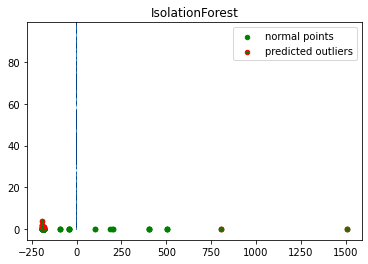

In [10]:
import numpy as np
from sklearn.decomposition import PCA
pca = PCA(2)
pca.fit(df[to_model_columns])
res=pd.DataFrame(pca.transform(df[to_model_columns]))
Z = np.array(res)
plt.title("IsolationForest")
plt.contourf( Z, cmap=plt.cm.Blues_r)
b1 = plt.scatter(res[0], res[1], c='green',
                 s=20,label="normal points")
b1 =plt.scatter(res.iloc[outlier_index,0],res.iloc[outlier_index,1], c='green',s=20,  edgecolor="red",label="predicted outliers")
plt.legend(loc="upper right")
plt.show()